# Φόρτωση Δεδομένων

### Βημα 1

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import torchtext

from PIL import Image
from pathlib import Path

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

# My imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from utils import classes, smooth
import numpy as np
import json

Στο παρακάτω code block, φορτώνονται τα δεδομένα και εισάγεται το dictionairy `classes` απο το `utils.py` αρχείο που περιέχει τις κλάσεις των δεδομένων συνοδευόμενες απο ένα σχετικό μοναδικό αριθμό (ID) το οποίο χρησιμεύει για τη δημιουργία των κλάσεων των νευρωνικών δικτύων

In [2]:
# Φορτώστε τα δεδομένα από τα CSV αρχεία χρησιμοποιώντας το pandas
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

print("classes:", json.dumps(classes, indent=4))

classes: {
    "apple_pie": 0,
    "cheesecake": 1,
    "chicken_curry": 2,
    "french_fries": 3,
    "fried_rice": 4,
    "hamburger": 5,
    "hot_dog": 6,
    "ice_cream": 7,
    "omelette": 8,
    "pizza": 9,
    "sushi": 10
}


Στον παραπάνω κώδικα, η κλάση `FoodDataset` δέχεται ένα DataFrame ως είσοδο κατά την αρχικοποίηση και μπορεί να εφαρμόσει μετασχηματισμούς στις εικόνες. Η μέθοδος `__getitem__` επιστρέφει την εικόνα και την ετικέτα της για ένα συγκεκριμένο δείγμα.

In [3]:
class FoodDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.class_to_idx = classes

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]  # Assuming the first column contains file paths
        image = Image.open(img_name)
        label = self.dataframe.iloc[idx, 1]  # Assuming the second column contains labels
        
        # Convert label to integer using class_to_idx dictionary
        label = self.class_to_idx[label]
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
# Διαίρεση σε σύνολα εκπαίδευσης και επικύρωσης
train_set, val_set = train_test_split(train_data, test_size=0.2, random_state=42)

# Ορίστε τους μετασχηματισμούς που επιθυμείτε να εφαρμόσετε στις εικόνες
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Αλλάξτε το μέγεθος των εικόνων σε 224x224
    transforms.ToTensor(),  # Μετατρέψτε τις εικόνες σε tensors
    # Προσθέστε άλλους μετασχηματισμούς που χρειάζεστε
])

# Δημιουργία των FoodDataset instances
train_dataset = FoodDataset(train_set, transform=transform)
val_dataset = FoodDataset(val_set, transform=transform)

# Δημιουργία των PyTorch Dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

Αυτός ο κώδικας θα δημιουργήσει τα train_loader και val_loader που θα χρησιμοποιηθούν για την εκπαίδευση και την επικύρωση του μοντέλου σας αντίστοιχα. Είναι σημαντικό να εισάγετε τις απαραίτητες βιβλιοθήκες όπως το torch, torchvision, PIL, και pandas, και να προσαρμόσετε τα μονοπάτια για τα αρχεία CSV και τα μετασχηματισμούς στις ανάγκες του προγράμματός σας.

### Βημα 2

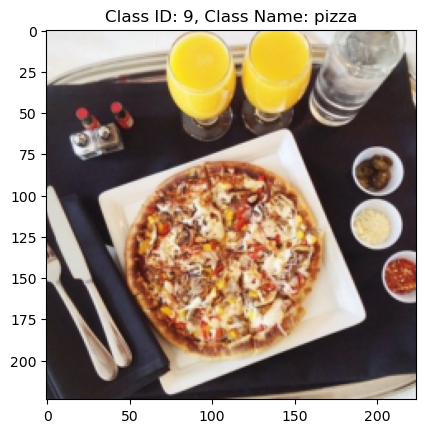

In [5]:
# Λειτουργία για να εμφανίζουμε τις εικόνες μαζί με το όνομα της κλάσης
def imshow_with_class(img, class_id, classes):
    class_name = list(classes.keys())[list(classes.values()).index(class_id)]
    plt.imshow(img.permute(1, 2, 0))  # Μετατροπή του tensor σε μορφή εικόνας (H, W, C)
    plt.title(f'Class ID: {class_id}, Class Name: {class_name}')
    plt.show()

# Λήψη ενός batch από τα δεδομένα εκπαίδευσης
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Εμφάνιση του πρώτου δείγματος από το batch
class_id = labels[0].item()
imshow_with_class(images[0], class_id, classes)

Αυτός ο κώδικας θα προβάλει την πρώτη εικόνα από το πρώτο batch, μαζί με την αντίστοιχη ετικέτα. Μπορείτε να το εκτελέσετε για να δείτε αν τα δεδομένα φορτώνονται σωστά και αν οι ετικέτες είναι σωστές.

### Βημα 3

Η συνάρτηση train_model θα πρέπει να εκπαιδεύει το μοντέλο για έναν συγκεκριμένο αριθμό εποχών, χρησιμοποιώντας έναν επιλεγμένο αλγόριθμο βελτιστοποίησης και ένα κριτήριο απώλειας. Κατά τη διάρκεια κάθε εποχής, θα πρέπει να υπολογίζονται οι μετρικές εκπαίδευσης και επικύρωσης για να ελεγχθεί η απόδοση του μοντέλου. Στο τέλος κάθε εποχής, θα πρέπει να αποθηκεύονται οι μετρικές αυτές για μελλοντική αναφορά.

Αυτή η συνάρτηση θα εκπαιδεύει το μοντέλο για τον αριθμό των εποχών που καθορίζετε. Κατά τη διάρκεια κάθε εποχής, υπολογίζονται οι μετρικές εκπαίδευσης και επικύρωσης και αποθηκεύονται για μελλοντική αναφορά. Επιστρέφει τα ιστορικά των μετρικών για εκπαίδευση και επικύρωση.

Ας προχωρήσουμε τώρα στη συνάρτηση evaluate_model.

Η συνάρτηση evaluate_model θα χρησιμοποιηθεί για τον έλεγχο της απόδοσης του μοντέλου σε ένα σύνολο δεδομένων, είτε στο σύνολο επικύρωσης είτε στο σύνολο δοκιμής. Αυτή η συνάρτηση θα υπολογίζει την απώλεια και την ακρίβεια του μοντέλου.

In [6]:
# Ορίζουμε τη συσκευή εκτέλεσης (device) που θα χρησιμοποιήσουμε
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device to be used during training: {device}")

# Ορίζουμε τη συνάρτηση εκπαίδευσης
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30):
    # Early stopping parameters
    patience=5
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    
    # Μετακινούμε το μοντέλο στη συσκευή εκτέλεσης
    model = model.to(device)

    # For training metrics
    train_loss_hist = []
    train_acc_hist = []
    val_loss_hist = []
    val_acc_hist = []

    metrics = {}
    
    # Ξεκινάμε την εκπαίδευση
    for epoch in range(num_epochs):
        # Θέτουμε το μοντέλο σε κατάσταση εκπαίδευσης
        model.train()
        
        # Αρχικοποίηση των μετρικών
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Εκπαίδευση του μοντέλου σε κάθε batch
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            images, labels = images.to(device), labels.to(device)
            
            # Μηδενίζουμε τις καταχωρήσεις των gradients
            optimizer.zero_grad()
            
            # Προϋπολογισμός των προβλέψεων
            outputs = model(images)
            
            # Υπολογισμός της απώλειας
            loss = criterion(outputs, labels)
            
            # Αντίστροφη διάδοση του σφάλματος και ενημέρωση των βαρών
            loss.backward()
            optimizer.step()
            
            # Καταγραφή της απώλειας
            running_loss += loss.item()
            
            # Υπολογισμός της ακρίβειας
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Εκτύπωση της απώλειας και της ακρίβειας στο σύνολο εκπαίδευσης
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        
        # Αξιολόγηση του μοντέλου στο σύνολο επικύρωσης
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Add to Metrics Dict
        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_accuracy)
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_accuracy)
        
        # Έλεγχος για πρόωρο τερματισμό αν δεν υπάρχει βελτίωση στο σύνολο επικύρωσης
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement == patience:
                print(f"No improvement for {patience} epochs. Early stopping...")
                break
        
        # Save metrics
        metrics['train_loss'] = train_loss_hist
        metrics['train_acc'] = train_acc_hist
        metrics['val_loss'] = val_loss_hist
        metrics['val_acc'] = val_acc_hist
        
    print("Training completed.")
    
    return metrics

# Ορίζουμε τη συνάρτηση αξιολόγησης
def evaluate_model(model, data_loader, criterion):
    # Θέτουμε το μοντέλο σε κατάσταση αξιολόγησης
    model.eval()
    
    # Αρχικοποίηση των μετρικών
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Αξιολόγηση του μοντέλου στα δεδομένα
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Υπολογισμός των προβλέψεων
            outputs = model(images)
            
            # Υπολογισμός της απώλειας
            loss = criterion(outputs, labels)
            
            # Καταγραφή της απώλειας
            running_loss += loss.item()
            
            # Υπολογισμός της ακρίβειας
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Υπολογισμός της απώλειας και της ακρίβειας
    loss = running_loss / len(data_loader)
    accuracy = correct / total
    
    return loss, accuracy

Device to be used during training: cuda


Αυτή η συνάρτηση αξιολογεί το μοντέλο στο δεδομένο data_loader, υπολογίζοντας την απώλεια και την ακρίβεια. Επιστρέφει επίσης την απώλεια και την ακρίβεια για μελλοντική αναφορά.

Αυτές οι συναρτήσεις μπορούν να χρησιμοποιηθούν για την εκπαίδευση και την αξιολόγηση ενός μοντέλου στο PyTorch.

### **1. Ποιος ο λόγος που έχουμε κρατήσει ένα κομμάτι του συνόλου εκπαίδευσης ως σύνολο επικύρωσης; ∆ε θα ήταν πιο λογικό να έχουμε περισσότερα δεδομένα για να εκπαιδεύσουμε τα μοντέλα μας; Εξηγήστε.**


Η κράτηση ενός κομματιού του συνόλου εκπαίδευσης ως σύνολο επικύρωσης έχει ως στόχο την αξιολόγηση της γενικευτικής ικανότητας του μοντέλου. Το σύνολο επικύρωσης χρησιμεύει για την επίβλεψη της απόδοσης του μοντέλου κατά τη διάρκεια της εκπαίδευσης και της προσαρμογής των υπερπαραμέτρων του μοντέλου (όπως ο ρυθμός μάθησης) ώστε να αποφευχθεί το overfitting. Η χρήση ενός ξεχωριστού συνόλου επικύρωσης βοηθά στην αποφυγή του overfitting και στη βελτίωση της γενίκευσης του μοντέλου. Αν εκπαιδεύαμε το μοντέλο με όλα τα δεδομένα, θα υπήρχε ο κίνδυνος να είναι πολύ καλό στο σύνολο εκπαίδευσης αλλά να μην γενικεύει καλά σε νέα δεδομένα.

### **2. Τί πρόβλημα καλούμαστε να λύσουμε στο συγκεκριμένο dataset; Ποια είναι η κατάλληλη συνάρτηση απώλειας για να εκπαιδεύσουμε ένα μοντέλο για ένα τέτοιου είδους προβλήματος;**

Το πρόβλημα που καλούμαστε να λύσουμε στο συγκεκριμένο dataset είναι η αναγνώριση της κατηγορίας των τροφίμων από εικόνες. Αυτό είναι ένα πρόβλημα ταξινόμησης πολλαπλών κατηγοριών, όπου κάθε εικόνα μπορεί να ανήκει σε μία από πολλές διαφορετικές κατηγορίες τροφίμων. Για την εκπαίδευση ενός μοντέλου για ένα τέτοιο πρόβλημα, μια κατάλληλη συνάρτηση απώλειας είναι η κατηγορική απώλεια (categorical cross-entropy), η οποία είναι κατάλληλη για την αναγνώριση πολλαπλών κατηγοριών.

# Εκπαίδευση Συνελικτικών ∆ικτύων

Αυτό το δίκτυο έχει τα επίπεδα που περιγράψατε, συμπεριλαμβανομένων τριών συνελικτικών επιπέδων, τριών επιπέδων συγκέντρωσης και ενός πλήρως συνδεδεμένου επιπέδου για την ταξινόμηση σε num_classes κλάσεις.

Αρχικοποιήστε το παραπάνω μοντέλο ΣΝ∆ και εκπαιδεύστε υλοποιώντας τα παρακάτω

• Αλγόριθμο βελτιστοποίησης Adam με ρυθμό εκμάθησης 10^4

• Εκτύπωση της απώλειας (loss), ορθότητας (accuracy) των υποσυνόλων εκπαίδευσης και επικύρωσης

• 30 εποχές μέγιστη διάρκεια εκπαίδευσης

• Πρόωρο τερματισμό της εκπαίδευσης (Early Stopping) αν δεν παρουσιαστεί μείωση της απώλειας στο
σύνολο επικύρωσης για 5 συνεχείς εποχές

In [7]:
class SmallNet(nn.Module):
    def __init__(self, num_classes=11):
        super(SmallNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc = nn.Linear(128 * 28 * 28, num_classes)  # 28x28 after 3 max pooling layers
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = x.view(x.size(0), -1)  # Flatten
        
        x = self.fc(x)
        return x

smallnet_model = SmallNet()

### Εκπαίδευση Συνελικτικών ∆ικτύων

In [8]:
# Create an instance of the BigNet model
smallnet_model = SmallNet()

# Ορίζουμε τον αλγόριθμο βελτιστοποίησης, το κριτήριο και τον βελτιστοποιητή
optimizer = optim.Adam(smallnet_model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# Εκπαιδεύουμε το μοντέλο
smallnet_model_metrics = train_model(smallnet_model, train_loader, val_loader, criterion, optimizer)

Epoch 1/30: 100%|██████████| 124/124 [00:18<00:00,  6.68it/s]


Train Loss: 2.2729, Train Accuracy: 0.1913
Validation Loss: 2.1505, Validation Accuracy: 0.2737


Epoch 2/30: 100%|██████████| 124/124 [00:18<00:00,  6.53it/s]


Train Loss: 2.0680, Train Accuracy: 0.2908
Validation Loss: 2.0714, Validation Accuracy: 0.2768


Epoch 3/30: 100%|██████████| 124/124 [00:19<00:00,  6.50it/s]


Train Loss: 1.9457, Train Accuracy: 0.3413
Validation Loss: 2.0149, Validation Accuracy: 0.3025


Epoch 4/30: 100%|██████████| 124/124 [00:19<00:00,  6.47it/s]


Train Loss: 1.8514, Train Accuracy: 0.3842
Validation Loss: 1.9690, Validation Accuracy: 0.3359


Epoch 5/30: 100%|██████████| 124/124 [00:19<00:00,  6.49it/s]


Train Loss: 1.7502, Train Accuracy: 0.4208
Validation Loss: 1.9493, Validation Accuracy: 0.3485


Epoch 6/30: 100%|██████████| 124/124 [00:19<00:00,  6.53it/s]


Train Loss: 1.6538, Train Accuracy: 0.4638
Validation Loss: 1.9611, Validation Accuracy: 0.3379


Epoch 7/30: 100%|██████████| 124/124 [00:19<00:00,  6.49it/s]


Train Loss: 1.5474, Train Accuracy: 0.4943
Validation Loss: 1.9352, Validation Accuracy: 0.3566


Epoch 8/30: 100%|██████████| 124/124 [00:19<00:00,  6.52it/s]


Train Loss: 1.4079, Train Accuracy: 0.5520
Validation Loss: 1.9468, Validation Accuracy: 0.3662


Epoch 9/30: 100%|██████████| 124/124 [00:18<00:00,  6.54it/s]


Train Loss: 1.2551, Train Accuracy: 0.6028
Validation Loss: 1.9813, Validation Accuracy: 0.3621


Epoch 10/30: 100%|██████████| 124/124 [00:19<00:00,  6.46it/s]


Train Loss: 1.1213, Train Accuracy: 0.6468
Validation Loss: 2.0190, Validation Accuracy: 0.3571


Epoch 11/30: 100%|██████████| 124/124 [00:19<00:00,  6.47it/s]


Train Loss: 0.9695, Train Accuracy: 0.7025
Validation Loss: 2.1055, Validation Accuracy: 0.3631


Epoch 12/30: 100%|██████████| 124/124 [00:19<00:00,  6.47it/s]


Train Loss: 0.8228, Train Accuracy: 0.7544
Validation Loss: 2.2005, Validation Accuracy: 0.3561
No improvement for 5 epochs. Early stopping...
Training completed.


### Αξιολόγηση

In [9]:
# Helper function with Exponential Weighted Moving Average implementation for smoothing the lines
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

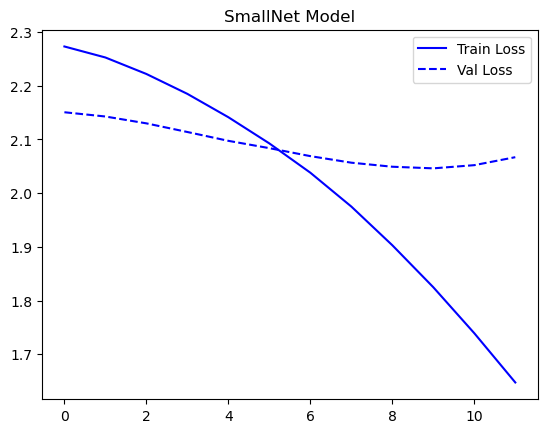

In [10]:
# Plot Train and Val losses
plt.plot(smooth(smallnet_model_metrics['train_loss'], 0.9), 'b')
plt.plot(smooth(smallnet_model_metrics['val_loss'], 0.9), 'b--')
plt.title('SmallNet Model')
plt.legend(['Train Loss', 'Val Loss'])

 ## Συνελικτικό δίκτυο μεγάλου βάθους

Αυτό το μοντέλο αντιστοιχεί στην περιγραφή που μου δώσατε, με τρία συνελικτικά επίπεδα ακολουθούμενα από επίπεδα συγκέντρωσης (Max pooling) και ένα πλήρως συνδεδεμένο επίπεδο στο τέλος.


Ο μεγάλος αριθμός επιπέδων και νευρώνων στο BigNet μοντέλο μπορεί να οδηγήσει σε προβλήματα υπερ-προσαρμογής (overfitting), ιδίως αν το μοντέλο δεν έχει κατάλληλη τεχνική ομαλοποίησης και ελέγχου χωρητικότητας.

Μια τεχνική ομαλοποίησης που μπορεί να χρησιμοποιηθεί είναι η απόσυρση (dropout). Η απόσυρση μπορεί να εφαρμοστεί μεταξύ των πλήρως συνδεδεμένων επιπέδων για να αποτρέψει την υπερ-προσαρμογή. Επιπλέον, μπορεί να χρησιμοποιηθεί η κανονικοποίηση βάρους (weight regularization), όπως η L2 κανονικοποίηση, για να ελέγξει το μέγεθος των βαρών του μοντέλου και να αποτρέψει την υπερ-προσαρμογή.

Ωστόσο, το παραπάνω BigNet μοντέλο δεν περιλαμβάνει αυτές τις τεχνικές. Για να προσθέσετε απόσυρση ή κανονικοποίηση βάρους, μπορείτε να προσθέσετε τα αντίστοιχα επίπεδα στο μοντέλο και να τα ενεργοποιήσετε κατά την εκπαίδευση.

In [11]:
class BigNet(nn.Module):
    def __init__(self, num_classes=11):
        super(BigNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 128 * 28 * 28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [12]:
# Create an instance of the BigNet model
bignet_model = BigNet()

# Ορίζουμε τον αλγόριθμο βελτιστοποίησης, το κριτήριο και τον βελτιστοποιητή
optimizer = optim.Adam(bignet_model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# Εκπαιδεύουμε το μοντέλο
bignet_model_metrics = train_model(bignet_model, train_loader, val_loader, criterion, optimizer)

Epoch 1/30: 100%|██████████| 124/124 [00:18<00:00,  6.55it/s]


Train Loss: 2.3035, Train Accuracy: 0.1664
Validation Loss: 2.2046, Validation Accuracy: 0.2121


Epoch 2/30: 100%|██████████| 124/124 [00:18<00:00,  6.55it/s]


Train Loss: 2.1279, Train Accuracy: 0.2548
Validation Loss: 2.1734, Validation Accuracy: 0.2444


Epoch 3/30: 100%|██████████| 124/124 [00:18<00:00,  6.56it/s]


Train Loss: 1.9830, Train Accuracy: 0.3212
Validation Loss: 1.9964, Validation Accuracy: 0.3045


Epoch 4/30: 100%|██████████| 124/124 [00:18<00:00,  6.64it/s]


Train Loss: 1.8588, Train Accuracy: 0.3715
Validation Loss: 1.9483, Validation Accuracy: 0.3303


Epoch 5/30: 100%|██████████| 124/124 [00:18<00:00,  6.59it/s]


Train Loss: 1.7331, Train Accuracy: 0.4181
Validation Loss: 1.9642, Validation Accuracy: 0.3293


Epoch 6/30: 100%|██████████| 124/124 [00:19<00:00,  6.47it/s]


Train Loss: 1.6135, Train Accuracy: 0.4609
Validation Loss: 1.9457, Validation Accuracy: 0.3540


Epoch 7/30: 100%|██████████| 124/124 [00:18<00:00,  6.72it/s]


Train Loss: 1.4442, Train Accuracy: 0.5225
Validation Loss: 1.9151, Validation Accuracy: 0.3646


Epoch 8/30: 100%|██████████| 124/124 [00:18<00:00,  6.60it/s]


Train Loss: 1.2777, Train Accuracy: 0.5851
Validation Loss: 1.9286, Validation Accuracy: 0.3697


Epoch 9/30: 100%|██████████| 124/124 [00:19<00:00,  6.51it/s]


Train Loss: 1.0884, Train Accuracy: 0.6476
Validation Loss: 1.9979, Validation Accuracy: 0.3672


Epoch 10/30: 100%|██████████| 124/124 [00:18<00:00,  6.55it/s]


Train Loss: 0.8957, Train Accuracy: 0.7149
Validation Loss: 2.1582, Validation Accuracy: 0.3556


Epoch 11/30: 100%|██████████| 124/124 [00:19<00:00,  6.50it/s]


Train Loss: 0.7004, Train Accuracy: 0.7876
Validation Loss: 2.3332, Validation Accuracy: 0.3480


Epoch 12/30: 100%|██████████| 124/124 [00:18<00:00,  6.54it/s]


Train Loss: 0.5264, Train Accuracy: 0.8470
Validation Loss: 2.4512, Validation Accuracy: 0.3611
No improvement for 5 epochs. Early stopping...
Training completed.


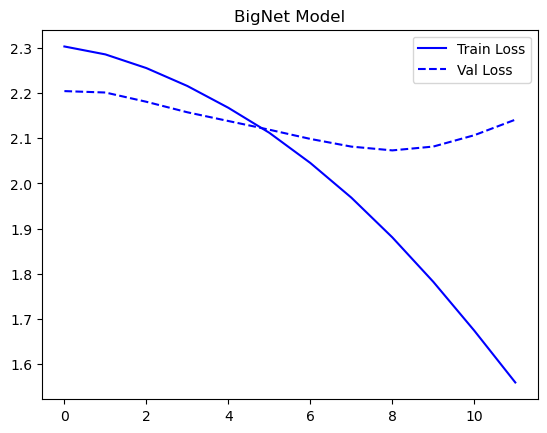

In [13]:
# Plot Train and Val losses
plt.plot(smooth(bignet_model_metrics['train_loss'], 0.9), 'b')
plt.plot(smooth(bignet_model_metrics['val_loss'], 0.9), 'b--')
plt.title('BigNet Model')
plt.legend(['Train Loss', 'Val Loss'])

Παρατηρείται πως η επίδοση του μεγαλύτερου μοντέλου δε φέρνει ιδιαίτερα διαφορετικά αποτελέσματα ως προς τη γενίκευση του παρόλο που αυξήθηκαν οι διαστάσεις του. Έτσι, μπορούμε να δοκιμάσουμε τεχικές ομαλοποίησης σε αυτό για να δούμε εαν αυτές θα επιφέρουν αλλαγές στην επίδοση του ξεκινώντας απο το περιορισμό των τιμών που μπορούν να πάρουν τα βάρη του δικτύου. Αυτό ρυθμίζεται μεσα στον `optimizer` ως παράμετρος της σχετικής συνάρτησης (`weight_decay`).

In [14]:
# Create an instance of the BigNet model
bignet_model_v2 = BigNet()

# Ορίζουμε τον αλγόριθμο βελτιστοποίησης, το κριτήριο και τον βελτιστοποιητή
optimizer = optim.Adam(bignet_model_v2.parameters(), lr=0.0001, weight_decay=0.0005)
criterion = nn.CrossEntropyLoss()

# Εκπαιδεύουμε το μοντέλο
bignet_model_v2_metrics = train_model(bignet_model_v2, train_loader, val_loader, criterion, optimizer)

Epoch 1/30: 100%|██████████| 124/124 [00:19<00:00,  6.48it/s]


Train Loss: 2.2829, Train Accuracy: 0.1801
Validation Loss: 2.1711, Validation Accuracy: 0.2283


Epoch 2/30: 100%|██████████| 124/124 [00:19<00:00,  6.50it/s]


Train Loss: 2.1197, Train Accuracy: 0.2537
Validation Loss: 2.0969, Validation Accuracy: 0.2626


Epoch 3/30: 100%|██████████| 124/124 [00:18<00:00,  6.60it/s]


Train Loss: 2.0036, Train Accuracy: 0.3077
Validation Loss: 2.0267, Validation Accuracy: 0.2904


Epoch 4/30: 100%|██████████| 124/124 [00:19<00:00,  6.41it/s]


Train Loss: 1.9201, Train Accuracy: 0.3448
Validation Loss: 1.9816, Validation Accuracy: 0.3404


Epoch 5/30: 100%|██████████| 124/124 [00:18<00:00,  6.55it/s]


Train Loss: 1.8358, Train Accuracy: 0.3783
Validation Loss: 1.9462, Validation Accuracy: 0.3333


Epoch 6/30: 100%|██████████| 124/124 [00:18<00:00,  6.65it/s]


Train Loss: 1.7428, Train Accuracy: 0.4168
Validation Loss: 1.9424, Validation Accuracy: 0.3369


Epoch 7/30: 100%|██████████| 124/124 [00:18<00:00,  6.69it/s]


Train Loss: 1.6593, Train Accuracy: 0.4479
Validation Loss: 1.9125, Validation Accuracy: 0.3439


Epoch 8/30: 100%|██████████| 124/124 [00:18<00:00,  6.64it/s]


Train Loss: 1.5512, Train Accuracy: 0.4852
Validation Loss: 1.9209, Validation Accuracy: 0.3631


Epoch 9/30: 100%|██████████| 124/124 [00:18<00:00,  6.53it/s]


Train Loss: 1.4635, Train Accuracy: 0.5129
Validation Loss: 1.9812, Validation Accuracy: 0.3379


Epoch 10/30: 100%|██████████| 124/124 [00:19<00:00,  6.44it/s]


Train Loss: 1.3384, Train Accuracy: 0.5605
Validation Loss: 2.0770, Validation Accuracy: 0.3379


Epoch 11/30: 100%|██████████| 124/124 [00:18<00:00,  6.59it/s]


Train Loss: 1.2109, Train Accuracy: 0.6076
Validation Loss: 2.0014, Validation Accuracy: 0.3439


Epoch 12/30: 100%|██████████| 124/124 [00:18<00:00,  6.60it/s]


Train Loss: 1.0473, Train Accuracy: 0.6640
Validation Loss: 2.0429, Validation Accuracy: 0.3621
No improvement for 5 epochs. Early stopping...
Training completed.


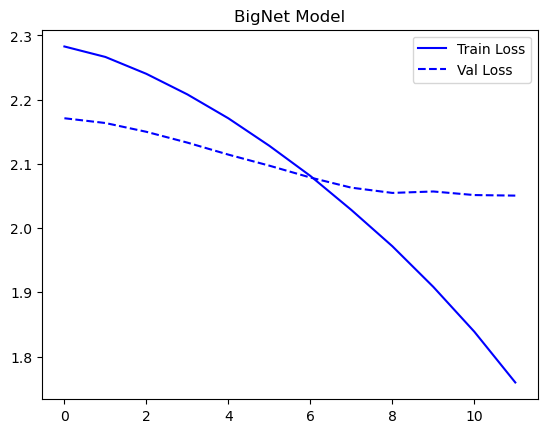

In [15]:
# Plot Train and Val losses
plt.plot(smooth(bignet_model_v2_metrics['train_loss'], 0.9), 'b')
plt.plot(smooth(bignet_model_v2_metrics['val_loss'], 0.9), 'b--')
plt.title('BigNet Model')
plt.legend(['Train Loss', 'Val Loss'])

Τα αποτελέσματα δε προσδίδουν κάποια εμφανή αλλαγή. Έτσι, επιστρατεύεται η τεχνική ομαλοποίησης "Dropout" η οποία αποκόπτει τυχαία μερίδα νευρώνων με κάποια πιθανότητα p από κάθε επίπεδο του δικτύου κατά τη διάρκεια κάθε εποχής εκπαίδευσης.

Αυτό έχει ως αποτέλεσμα το δίκτυο να μην μπορεί να βασιστεί υπερβολικά σε συγκεκριμένους νευρώνες και να αναπτύσσει πιο γενικευμένα χαρακτηριστικά.

Προστίθεται έτσι ενα επίπεδο Dropout μετά απο επίπδα συνέλιξης με πιθανότητα 0.5

In [16]:
import torch.nn as nn

class BigNetDropout(nn.Module):
    def __init__(self, num_classes=11):
        super(BigNetDropout, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)  # Ορίζουμε την πιθανότητα dropout (εδώ 0.5)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)  # Προσθήκη Dropout μετά το πρώτο max pooling layer
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)  # Προσθήκη Dropout μετά το δεύτερο max pooling layer
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)  # Προσθήκη Dropout μετά το τρίτο max pooling layer
        x = x.view(-1, 128 * 28 * 28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)  # Προσθήκη Dropout μετά το πρώτο fully connected layer
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)  # Προσθήκη Dropout μετά το δεύτερο fully connected layer
        x = self.fc3(x)
        return x


In [17]:
# Dropout Net
bignet_model_v3 = BigNetDropout()

# Ορίζουμε τον αλγόριθμο βελτιστοποίησης, το κριτήριο και τον βελτιστοποιητή
optimizer = optim.Adam(bignet_model_v3.parameters(), lr=0.0001, weight_decay=0.0005)
criterion = nn.CrossEntropyLoss()

# Εκπαιδεύουμε το μοντέλο
bignet_model_v3_metrics = train_model(bignet_model_v3, train_loader, val_loader, criterion, optimizer)

Epoch 1/30: 100%|██████████| 124/124 [00:19<00:00,  6.52it/s]


Train Loss: 2.4074, Train Accuracy: 0.0917
Validation Loss: 2.3968, Validation Accuracy: 0.0939


Epoch 2/30: 100%|██████████| 124/124 [00:19<00:00,  6.41it/s]


Train Loss: 2.3825, Train Accuracy: 0.1178
Validation Loss: 2.3565, Validation Accuracy: 0.1470


Epoch 3/30: 100%|██████████| 124/124 [00:19<00:00,  6.38it/s]


Train Loss: 2.3147, Train Accuracy: 0.1568
Validation Loss: 2.3178, Validation Accuracy: 0.1495


Epoch 4/30: 100%|██████████| 124/124 [00:19<00:00,  6.38it/s]


Train Loss: 2.2843, Train Accuracy: 0.1742
Validation Loss: 2.3051, Validation Accuracy: 0.1581


Epoch 5/30: 100%|██████████| 124/124 [00:19<00:00,  6.41it/s]


Train Loss: 2.2626, Train Accuracy: 0.1910
Validation Loss: 2.2779, Validation Accuracy: 0.2020


Epoch 6/30: 100%|██████████| 124/124 [00:19<00:00,  6.38it/s]


Train Loss: 2.2189, Train Accuracy: 0.2119
Validation Loss: 2.2544, Validation Accuracy: 0.2202


Epoch 7/30: 100%|██████████| 124/124 [00:19<00:00,  6.33it/s]


Train Loss: 2.1841, Train Accuracy: 0.2218
Validation Loss: 2.2145, Validation Accuracy: 0.2490


Epoch 8/30: 100%|██████████| 124/124 [00:19<00:00,  6.34it/s]


Train Loss: 2.1464, Train Accuracy: 0.2372
Validation Loss: 2.1762, Validation Accuracy: 0.2540


Epoch 9/30: 100%|██████████| 124/124 [00:19<00:00,  6.38it/s]


Train Loss: 2.1176, Train Accuracy: 0.2564
Validation Loss: 2.1712, Validation Accuracy: 0.2409


Epoch 10/30: 100%|██████████| 124/124 [00:18<00:00,  6.55it/s]


Train Loss: 2.0979, Train Accuracy: 0.2668
Validation Loss: 2.1344, Validation Accuracy: 0.2778


Epoch 11/30: 100%|██████████| 124/124 [00:19<00:00,  6.41it/s]


Train Loss: 2.0714, Train Accuracy: 0.2777
Validation Loss: 2.1223, Validation Accuracy: 0.2778


Epoch 12/30: 100%|██████████| 124/124 [00:19<00:00,  6.34it/s]


Train Loss: 2.0470, Train Accuracy: 0.2864
Validation Loss: 2.1068, Validation Accuracy: 0.2712


Epoch 13/30: 100%|██████████| 124/124 [00:19<00:00,  6.38it/s]


Train Loss: 2.0063, Train Accuracy: 0.3076
Validation Loss: 2.0869, Validation Accuracy: 0.2924


Epoch 14/30: 100%|██████████| 124/124 [00:19<00:00,  6.40it/s]


Train Loss: 1.9944, Train Accuracy: 0.3150
Validation Loss: 2.0890, Validation Accuracy: 0.2798


Epoch 15/30: 100%|██████████| 124/124 [00:19<00:00,  6.45it/s]


Train Loss: 1.9679, Train Accuracy: 0.3308
Validation Loss: 2.0652, Validation Accuracy: 0.3045


Epoch 16/30: 100%|██████████| 124/124 [00:19<00:00,  6.39it/s]


Train Loss: 1.9358, Train Accuracy: 0.3394
Validation Loss: 2.0514, Validation Accuracy: 0.3111


Epoch 17/30: 100%|██████████| 124/124 [00:19<00:00,  6.40it/s]


Train Loss: 1.9102, Train Accuracy: 0.3441
Validation Loss: 2.0471, Validation Accuracy: 0.3020


Epoch 18/30: 100%|██████████| 124/124 [00:19<00:00,  6.46it/s]


Train Loss: 1.8763, Train Accuracy: 0.3650
Validation Loss: 2.0301, Validation Accuracy: 0.3116


Epoch 19/30: 100%|██████████| 124/124 [00:19<00:00,  6.32it/s]


Train Loss: 1.8302, Train Accuracy: 0.3814
Validation Loss: 2.0654, Validation Accuracy: 0.2854


Epoch 20/30: 100%|██████████| 124/124 [00:19<00:00,  6.35it/s]


Train Loss: 1.7965, Train Accuracy: 0.3802
Validation Loss: 2.0304, Validation Accuracy: 0.3045


Epoch 21/30: 100%|██████████| 124/124 [00:18<00:00,  6.53it/s]


Train Loss: 1.7821, Train Accuracy: 0.3981
Validation Loss: 1.9862, Validation Accuracy: 0.3242


Epoch 22/30: 100%|██████████| 124/124 [00:18<00:00,  6.62it/s]


Train Loss: 1.7071, Train Accuracy: 0.4279
Validation Loss: 2.0159, Validation Accuracy: 0.3177


Epoch 23/30: 100%|██████████| 124/124 [00:19<00:00,  6.34it/s]


Train Loss: 1.6727, Train Accuracy: 0.4348
Validation Loss: 2.0050, Validation Accuracy: 0.3247


Epoch 24/30: 100%|██████████| 124/124 [00:19<00:00,  6.47it/s]


Train Loss: 1.6210, Train Accuracy: 0.4558
Validation Loss: 2.0236, Validation Accuracy: 0.3096


Epoch 25/30: 100%|██████████| 124/124 [00:18<00:00,  6.54it/s]


Train Loss: 1.5717, Train Accuracy: 0.4638
Validation Loss: 1.9812, Validation Accuracy: 0.3258


Epoch 26/30: 100%|██████████| 124/124 [00:19<00:00,  6.42it/s]


Train Loss: 1.5103, Train Accuracy: 0.4908
Validation Loss: 2.0095, Validation Accuracy: 0.3025


Epoch 27/30: 100%|██████████| 124/124 [00:19<00:00,  6.49it/s]


Train Loss: 1.4535, Train Accuracy: 0.5133
Validation Loss: 2.0155, Validation Accuracy: 0.3086


Epoch 28/30: 100%|██████████| 124/124 [00:19<00:00,  6.41it/s]


Train Loss: 1.4058, Train Accuracy: 0.5326
Validation Loss: 2.0224, Validation Accuracy: 0.3141


Epoch 29/30: 100%|██████████| 124/124 [00:18<00:00,  6.53it/s]


Train Loss: 1.3537, Train Accuracy: 0.5453
Validation Loss: 2.0005, Validation Accuracy: 0.3258


Epoch 30/30: 100%|██████████| 124/124 [00:19<00:00,  6.33it/s]


Train Loss: 1.2704, Train Accuracy: 0.5711
Validation Loss: 2.0188, Validation Accuracy: 0.3293
No improvement for 5 epochs. Early stopping...
Training completed.


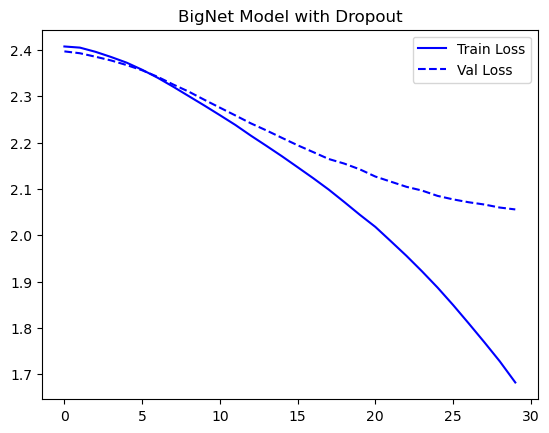

In [18]:
# Plot Train and Val losses
plt.plot(smooth(bignet_model_v3_metrics['train_loss'], 0.9), 'b')
plt.plot(smooth(bignet_model_v3_metrics['val_loss'], 0.9), 'b--')
plt.title('BigNet Model with Dropout')
plt.legend(['Train Loss', 'Val Loss'])

Η τεχνική Dropout φαίνεται να βοήθησε αρκετά καθότι πλέον το μοντέλο δείχνει να μπορεί να γενικεύει ωστόσο όχι σε ικανοποιητικό βαθμό. Επίσης το γεγονός της μη ενεργοποίησης του early stopping είναι δείγμα της βελτίωσης του.

# Προεκπαιδευμένο Νευρωνικό ∆ίκτυο

In [232]:
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
# Initialize model with the best available weights
weights = ResNet50_Weights.IMAGENET1K_V2
resnet50_model = resnet50(weights=weights)
# Change Models Last FC Layer
# Το αφήνουμε για εσάς

# Define the number of classes for your specific task
num_classes = 11  # For example, if you have 10 classes

# Get the number of input features for the last layer of ResNet50
num_features = resnet50_model.fc.in_features

# Define a new fully connected layer
new_fc = nn.Linear(num_features, num_classes)

# Replace the last fully connected layer of ResNet50 with the new one
resnet50_model.fc = new_fc

In [233]:
# Ορίζουμε τον αλγόριθμο βελτιστοποίησης, το κριτήριο και τον βελτιστοποιητή
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.0001, weight_decay=0.0005)
criterion = nn.CrossEntropyLoss()

# Εκπαιδεύουμε το μοντέλο
resnet50_model_metrics = train_model(resnet50_model, train_loader, val_loader, criterion, optimizer)

Epoch 1/30: 100%|██████████| 124/124 [00:31<00:00,  3.95it/s]


Train Loss: 1.0688, Train Accuracy: 0.7158
Validation Loss: 0.4301, Validation Accuracy: 0.8702


Epoch 2/30: 100%|██████████| 124/124 [00:31<00:00,  3.98it/s]


Train Loss: 0.2378, Train Accuracy: 0.9323
Validation Loss: 0.3711, Validation Accuracy: 0.8934


Epoch 3/30: 100%|██████████| 124/124 [00:31<00:00,  3.97it/s]


Train Loss: 0.0795, Train Accuracy: 0.9799
Validation Loss: 0.3667, Validation Accuracy: 0.8909


Epoch 4/30: 100%|██████████| 124/124 [00:31<00:00,  4.00it/s]


Train Loss: 0.0346, Train Accuracy: 0.9908
Validation Loss: 0.4119, Validation Accuracy: 0.8833


Epoch 5/30: 100%|██████████| 124/124 [00:30<00:00,  4.00it/s]


Train Loss: 0.0192, Train Accuracy: 0.9956
Validation Loss: 0.3885, Validation Accuracy: 0.8965


Epoch 6/30: 100%|██████████| 124/124 [00:31<00:00,  3.95it/s]


Train Loss: 0.0172, Train Accuracy: 0.9963
Validation Loss: 0.4178, Validation Accuracy: 0.8884


Epoch 7/30: 100%|██████████| 124/124 [00:31<00:00,  3.97it/s]


Train Loss: 0.0296, Train Accuracy: 0.9912
Validation Loss: 0.5127, Validation Accuracy: 0.8697


Epoch 8/30: 100%|██████████| 124/124 [00:31<00:00,  3.97it/s]


Train Loss: 0.0334, Train Accuracy: 0.9912
Validation Loss: 0.4869, Validation Accuracy: 0.8793
No improvement for 5 epochs. Early stopping...
Training completed.


<class 'torchvision.models.resnet.ResNet'>


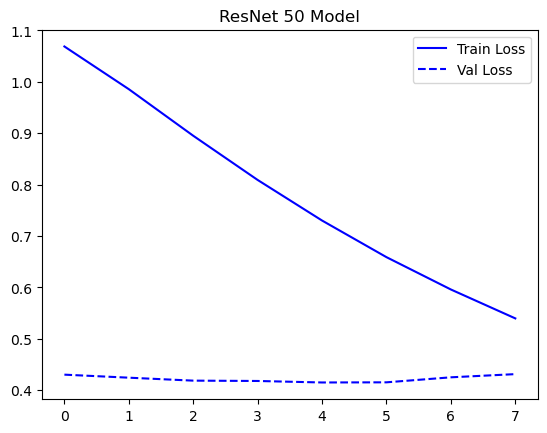

In [234]:
# Plot Train and Val losses
plt.plot(smooth(resnet50_model_metrics['train_loss'], 0.9), 'b')
plt.plot(smooth(resnet50_model_metrics['val_loss'], 0.9), 'b--')
plt.title('ResNet 50 Model')
plt.legend(['Train Loss', 'Val Loss'])

print(type(resnet50_model))

In [235]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, dataloaders, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0    
    fig, axes = plt.subplots(2, 3, figsize=(10, 6))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                row = images_so_far // 3
                col = images_so_far % 3
                ax = axes[row, col]
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                ax.imshow(inputs.cpu().data[j].permute(1, 2, 0))
                images_so_far += 1

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

    model.train(mode=was_training)

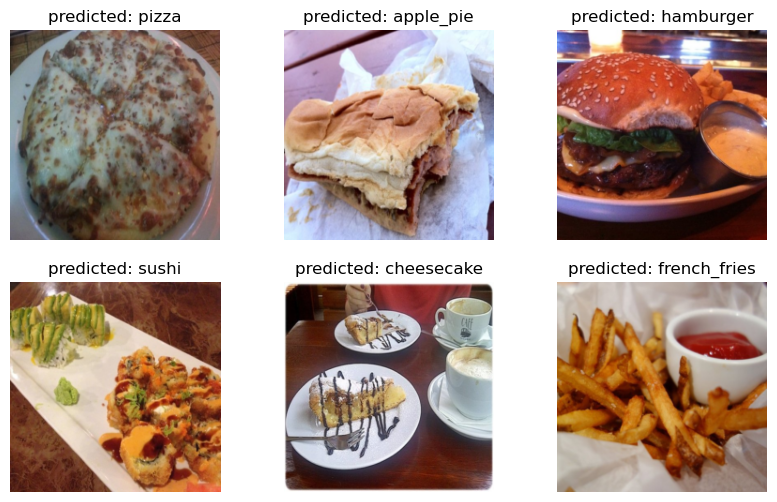

In [236]:
visualize_model(resnet50_model, val_loader)

# BONUS

Inspect the Model's Output: Print out the outputs tensor and examine its values. If the values are consistently low or high, it might indicate a problem with the model's weights or architecture.

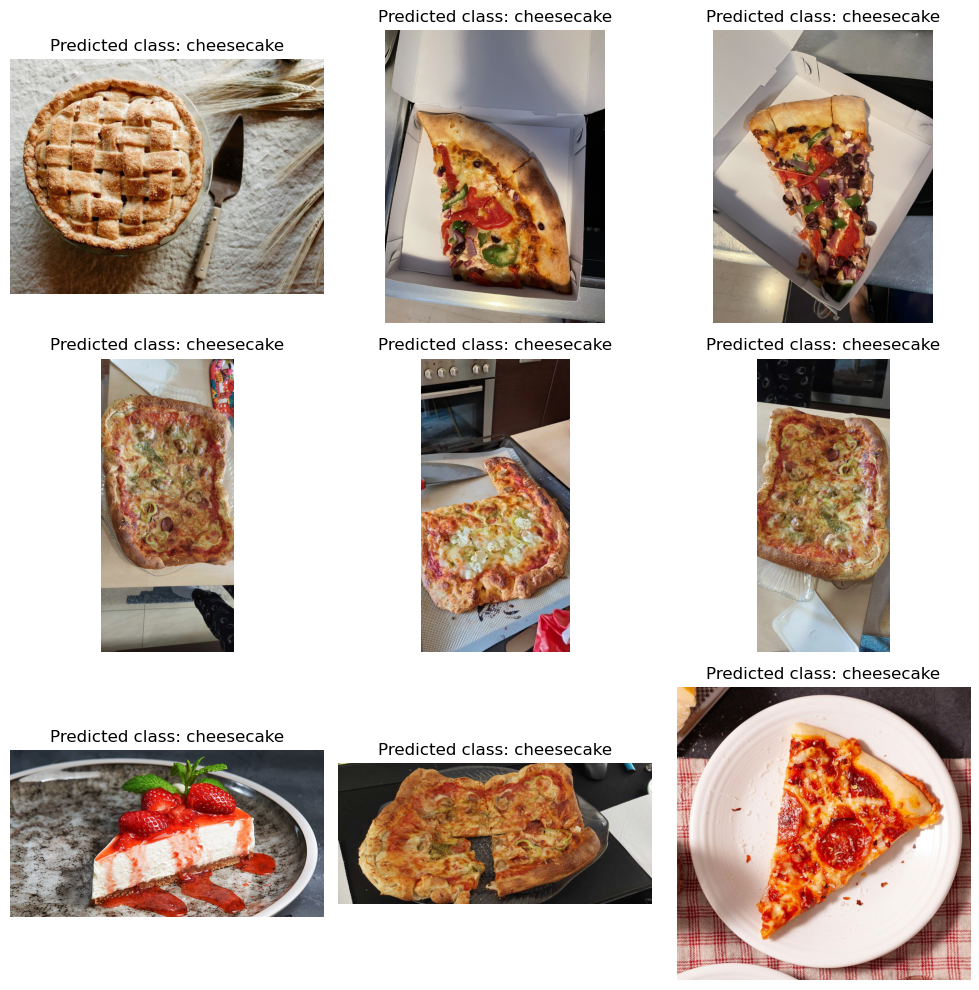

In [241]:
import os
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from PIL import Image

custom_images_path = "my_data"

# Assuming `resnet50_model`, `device`, and `class_names` are defined elsewhere in your code
model = resnet50_model

# List all files in the directory
custom_images = os.listdir(custom_images_path)
custom_images = [entry for entry in custom_images if '.' in entry and not entry.startswith('.')]
num_images = len(custom_images)

# Determine the number of rows and columns for the subplot grid
num_rows = int(num_images ** 0.5)
num_cols = (num_images + num_rows - 1) // num_rows

# Create a subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Loop through custom images and plot them in the subplot grid
for i, custom_image in enumerate(custom_images):
    image = Image.open(os.path.join(custom_images_path, custom_image))
    
    model.to(device)
    # Ensure the model is in evaluation mode before passing the image.
    model.eval()
    
    # Convert the custom image to tensor and move it to the appropriate device.
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    custom_image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Forward pass through the model
    with torch.no_grad():
        outputs = model(custom_image_tensor)
        _, predicted = torch.max(outputs, 1)
    
    # Get the predicted class label
    predicted_class = class_names[predicted.item()]
    
    # Plot the image in the corresponding subplot
    row_index = i // num_cols
    col_index = i % num_cols
    ax = axes[row_index, col_index]
    ax.imshow(image)
    ax.set_title(f'Predicted class: {predicted_class}')
    ax.axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()